
Hyperparameter tuning: Linear Regression
MAE: 54.78 | RMSE: 91.51 | R²: 0.9234


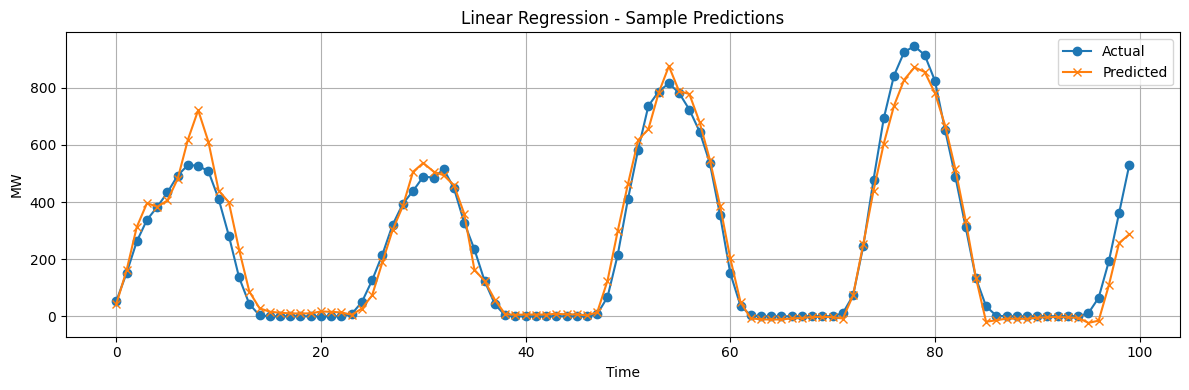


Hyperparameter tuning: SVR (RBF)
MAE: 51.23 | RMSE: 91.40 | R²: 0.9236


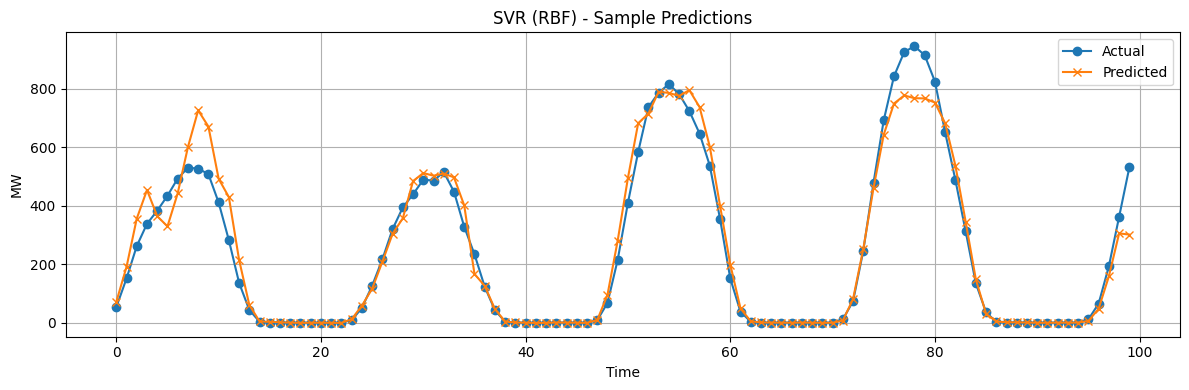


Hyperparameter tuning: Random Forest
MAE: 48.98 | RMSE: 92.36 | R²: 0.9220


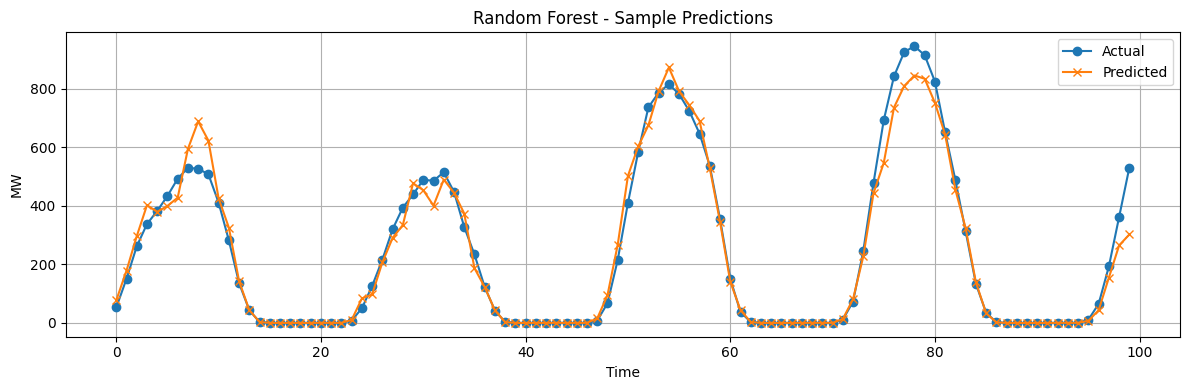


Hyperparameter tuning: XGBoost
MAE: 50.19 | RMSE: 90.03 | R²: 0.9259


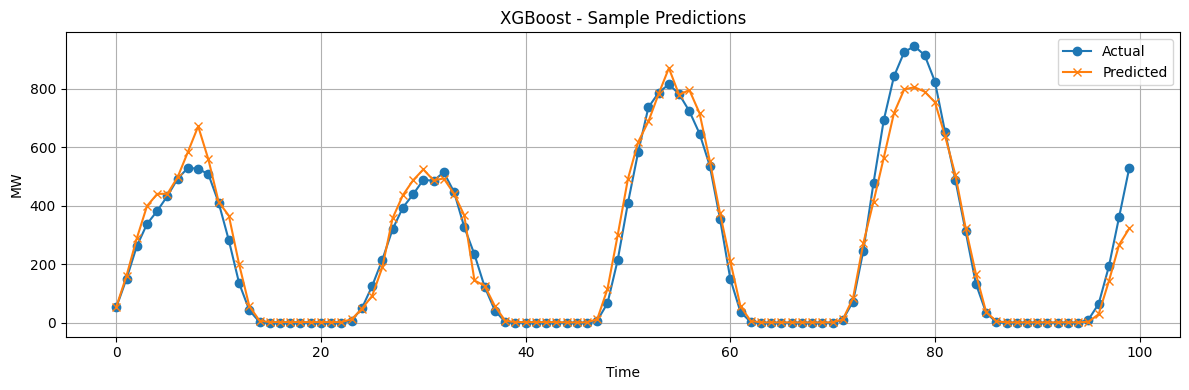


Summary:
               model                                     best_estimator  \
0  Linear Regression             (StandardScaler(), LinearRegression())   
1          SVR (RBF)                      (StandardScaler(), SVR(C=10))   
2      Random Forest  (StandardScaler(), (DecisionTreeRegressor(max_...   
3            XGBoost  (StandardScaler(), XGBRegressor(base_score=Non...   

                                         best_params        mae       rmse  \
0                                                 {}  54.780003  91.510473   
1  {'model__C': 10, 'model__gamma': 'scale', 'mod...  51.227796  91.401905   
2  {'model__max_depth': None, 'model__min_samples...  48.982794  92.363742   
3  {'model__learning_rate': 0.05, 'model__max_dep...  50.185829  90.027559   

         r2  
0  0.923399  
1  0.923581  
2  0.921964  
3  0.925862  
XGBoost model saved successfully.


In [6]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer

from xgboost import XGBRegressor

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import joblib
import os

DATA_PATH = os.path.join("..", "data", "processed")

df = pd.read_csv("../data/processed/merged_data.csv", parse_dates=["utc_timestamp"])

# Create time-based features
df["hour"] = df["utc_timestamp"].dt.hour
df["day"] = df["utc_timestamp"].dt.day
df["month"] = df["utc_timestamp"].dt.month
df["dayofweek"] = df["utc_timestamp"].dt.dayofweek
df["is_weekend"] = df["dayofweek"].isin([5, 6]).astype(int)

# Drop timestamp and build X and y
target_col = "generation_actual"
drop_cols = ["utc_timestamp", target_col]

feature_cols = [col for col in df.columns if col not in drop_cols]

X = df[feature_cols]
y = df[target_col]

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Since this is time-series data, avoid random splitting
split_index = int(len(X_scaled) * 0.8)

X_train = X_scaled.iloc[:split_index]
X_test  = X_scaled.iloc[split_index:]

y_train = y.iloc[:split_index]
y_test  = y.iloc[split_index:]

imputer = SimpleImputer(strategy="median")
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

X_train.to_csv(os.path.join(DATA_PATH, "x_train.csv"), index=False)
X_test.to_csv(os.path.join(DATA_PATH, "x_test.csv"), index=False)

y_train.to_csv(os.path.join(DATA_PATH, "y_train.csv"), index=False)
y_test.to_csv(os.path.join(DATA_PATH, "y_test.csv"), index=False)

models_and_params = {
    'Linear Regression': {
        'model': LinearRegression(),
        'params': {
            # No hyperparams for basic LinearRegression
        }
    },
    'SVR (RBF)': {
        'model': SVR(),
        'params': {
            'model__C': [0.1, 1, 10],
            'model__gamma': ['scale', 'auto'],
            'model__kernel': ['rbf']
        }
    },
    'Random Forest': {
        'model': RandomForestRegressor(random_state=42),
        'params': {
            'model__n_estimators': [100, 200],
            'model__max_depth': [None, 3, 5],
            'model__min_samples_split': [2, 5]
        }
    },
    'XGBoost': {
        'model': XGBRegressor(random_state=42, objective='reg:squarederror'),
        'params': {
            'model__n_estimators': [100, 200],
            'model__learning_rate': [0.01, 0.05, 0.1],
            'model__max_depth': [3, 6]
        }
    }
}

results = []

for name, cfg in models_and_params.items():
    print(f"\nHyperparameter tuning: {name}")

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', cfg['model'])
    ])

    search = GridSearchCV(
        pipeline,
        param_grid=cfg['params'],
        scoring='neg_mean_absolute_error',
        cv=3,
        n_jobs=-1,
        verbose=0
    )

    search.fit(X_train, y_train)
    best_model = search.best_estimator_

    y_pred = best_model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results.append({
        'model': name,
        'best_estimator': search.best_estimator_,
        'best_params': search.best_params_,
        'mae': mae,
        'rmse': rmse,
        'r2': r2
    })

    print(f"MAE: {mae:.2f} | RMSE: {rmse:.2f} | R²: {r2:.4f}")

    plt.figure(figsize=(12, 4))
    plt.plot(y_test.values[:100], label="Actual", marker='o')
    plt.plot(y_pred[:100], label="Predicted", marker='x')
    plt.title(f"{name} - Sample Predictions")
    plt.xlabel("Time")
    plt.ylabel("MW")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


df_results = pd.DataFrame(results)
print("\nSummary:")
print(df_results)

"""
Summary:

0  Linear Regression    
1          SVR (RBF)     
2      Random Forest  
3            XGBoost

         MAE       RMSE        R²  
0  54.780003  91.510473  0.923399  
1  51.227796  91.401905  0.923581  
2  48.982794  92.363742  0.921964  
3  50.185829  90.027559  0.925862 

XGBoost with tuned hyperparameters performed the best across RMSE and R², with SVR very close behind.
"""

xgb_result = next(res for res in results if res["model"] == "XGBoost")

os.makedirs("../models", exist_ok=True)
joblib.dump(xgb_result["best_estimator"], "../models/best_model.pkl")
print("XGBoost model saved successfully.")